# **elmo1-rhog_nanobody_design**

## **Fig. 3b**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import hdbscan

In [ ]:
def singleline(fasta_file):

    filein = open(fasta_file, 'r', encoding='utf-8')
    fasta = filein.readlines()
    filein.close()

    for i in range(len(fasta)-1):
        if fasta[i].count('>') == 1:
            pass
        elif fasta[i].count('>') == 0 and fasta[i+1].count('>') == 0:
            fasta[i] = fasta[i].replace('\n','')
        elif fasta[i].count('>') == 0 and fasta[i+1].count('>') == 1:
            pass

    return ''.join(fasta).split("\n")

def singleline2array(singleline_output):
    
    singlieline_output_join = ''.join(singleline_output[1::2])
        
    import numpy as np
    
    tmp_list = []
    
    for i in singlieline_output_join:
        tmp_list.append(i)
    
    return np.array(tmp_list).reshape(int((len(singleline_output)-1)/2),len(singleline_output[1]))

def aa2descriptors(singleline2array_output):
    
    import numpy as np
    import pandas as pd
    
    df = pd.read_csv('aaDescriptors.csv')
    df = df.set_index('aa')
    df_transpose = df.transpose()
    aaDescriptors_dict = df_transpose.to_dict()
    
    aaDescriptors_elements = list(pd.read_csv('aaDescriptors.csv').columns.values)[1:]
    
    translate_tmp_list = []
    
    for i in range(singleline2array_output.shape[0]):
        for j in range(singleline2array_output.shape[1]):
            for elem in aaDescriptors_elements:
                translate_tmp_list.append(aaDescriptors_dict.get(singleline2array_output[i][j], {}).get(elem))
                
    return np.array(translate_tmp_list).reshape(singleline2array_output.shape[0],singleline2array_output.shape[1]*len(aaDescriptors_elements))

def desciptorsPCA(aa2descriptors_output):
    
    import numpy as np
    import pandas as pd
    from sklearn.preprocessing import StandardScaler
    from sklearn.impute import SimpleImputer
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    global principalDf
    global descriptor_standardized_replacedNaN
    
    descriptor_standardized = StandardScaler().fit_transform(aa2descriptors_output)
    
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    descriptor_standardized_replacedNaN = imp_mean.fit_transform(descriptor_standardized)
    
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(descriptor_standardized_replacedNaN)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])
    
    sns.set(style="whitegrid")
    f, ax = plt.subplots(figsize=(6.5, 6.5))
    sns.despine(f, left=True, bottom=True)
    sns.scatterplot(x="PC1", y="PC2", data=principalDf)
    
    return sns

def descriptorsTSNE():

    import matplotlib.pyplot as plt
    import seaborn as sns
    %matplotlib inline
    import pandas as pd
    from sklearn.manifold import TSNE

    tsne = TSNE(n_components=2, random_state=0)

    return tsne.fit_transform(descriptor_standardized_replacedNaN)

def cluster_PC(component_df, min_cluster_size, min_samples, cluster_selection_epsilon, alpha):

    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import sklearn.datasets as data
    import hdbscan
    %matplotlib inline
    sns.set_context('poster')
    sns.set_style('white')
    sns.set_color_codes()
    plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}
    
    global cluster_np_PC

    component_df_np = np.array(component_df)

    clusterer = hdbscan.HDBSCAN(min_cluster_size = min_cluster_size,                     ### Larger the min_cluster_size, decrease the number of clusters by merging.
                                min_samples = min_samples,                               ### Larger the min_samples, the more conservative the clustering – more points will be declared as noise, and clusters will be restricted to progressively more dense areas.
                                cluster_selection_epsilon = cluster_selection_epsilon,   ### Larger the value of cluster_selection_epsilon, clusters merge.
                                alpha = alpha,                                           ### Best not to mess with this parameter – ultimately it is part of the RobustSingleLinkage code, but flows naturally into HDBSCAN. By default alpha is set to 1.0. Increasing alpha will make the clustering more conservative, but on a much tighter scale, as we can see by setting alpha to 1.3.
                                gen_min_span_tree=True)

    clusterer.fit(component_df_np)

    palette = sns.color_palette()

    cluster_colors = [sns.desaturate(palette[col], sat)
                      if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
                      zip(clusterer.labels_, clusterer.probabilities_)]
    
    cluster_np_PC = clusterer.labels_.reshape(len(clusterer.labels_),1)

    return plt.scatter(component_df_np.T[0], component_df_np.T[1], c=cluster_colors, **plot_kwds)

def cluster_tsne(component_df, min_cluster_size, min_samples, cluster_selection_epsilon, alpha):

    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import sklearn.datasets as data
    import hdbscan
    %matplotlib inline
    sns.set_context('poster')
    sns.set_style('white')
    sns.set_color_codes()
    plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}
    
    global cluster_np_tsne

    component_df_np = np.array(component_df)

    clusterer = hdbscan.HDBSCAN(min_cluster_size = min_cluster_size,                     ### Larger the min_cluster_size, decrease the number of clusters by merging.
                                min_samples = min_samples,                               ### Larger the min_samples, the more conservative the clustering – more points will be declared as noise, and clusters will be restricted to progressively more dense areas.
                                cluster_selection_epsilon = cluster_selection_epsilon,   ### Larger the value of cluster_selection_epsilon, clusters merge.
                                alpha = alpha,                                           ### Best not to mess with this parameter – ultimately it is part of the RobustSingleLinkage code, but flows naturally into HDBSCAN. By default alpha is set to 1.0. Increasing alpha will make the clustering more conservative, but on a much tighter scale, as we can see by setting alpha to 1.3.
                                gen_min_span_tree=True)

    clusterer.fit(component_df_np)

    palette = sns.color_palette()

    cluster_colors = [sns.desaturate(palette[col], sat)
                      if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
                      zip(clusterer.labels_, clusterer.probabilities_)]
    
    cluster_np_tsne = clusterer.labels_.reshape(len(clusterer.labels_),1)

    return plt.scatter(component_df_np.T[0], component_df_np.T[1], c=cluster_colors, **plot_kwds)

def find_PCA_centroid():
    
    PC_cluster = np.array(combine_matrix_output.iloc[0:,5:6])
    PC_cluster_uniq = {i for s in PC_cluster for i in s}

    df_list = []

    for i in PC_cluster_uniq:
        df_list.append(pd.DataFrame(combine_matrix_output.loc[combine_matrix_output['PCA_cluster'] == i]))

    center = []    

    for i in df_list:
        length = i.shape[0]
        sum_x = sum(i.iloc[:, 1])
        sum_y = sum(i.iloc[:, 2])
        center.append(np.array([sum_x/length, sum_y/length]))

    points = []    

    for i in df_list:
        points.append(np.array(i.iloc[:,1:3]))
    
    center_tile = []
    points_center = []
    points_center_dist = []
    points_center_dist_min = []

    for i in range(len(center)):
        center_tile.append(np.tile(center[i], len(points[i])).reshape(len(points[i]),2))
        points_center.append(np.concatenate((points[i],center_tile[i]), axis = 1))

        column0 = points_center[i][:,0:1]
        column1 = points_center[i][:,1:2]
        column2 = points_center[i][:,2:3]
        column3 = points_center[i][:,3:4]
        new_column = ((column0 - column2)**2 + (column1 - column3)**2)**(1/2)
        points_center[i] = np.hstack((points_center[i], new_column))

        points_center_dist_min.append(points_center[i][np.argmin(points_center[i][:, 4]), :])

    combine_matrix_output.insert(loc=7, column='PCA_centroid', value='')

    for i in range(len(combine_matrix_output)):
        for j in range(len(points_center_dist_min)):
            if np.array(points_center_dist_min[j][0]) == np.array(combine_matrix_output.iloc[i:i+1,1:2]) and np.array(points_center_dist_min[j][1]) == np.array(combine_matrix_output.iloc[i:i+1,2:3]):
                combine_matrix_output.iloc[i,7] = 'centroid'

    return combine_matrix_output

def find_tSNE_centroid():
    
    tSNE_cluster = np.array(combine_matrix_output.iloc[0:,6:7])
    tSNE_cluster_uniq = {i for s in tSNE_cluster for i in s}

    df_list = []

    for i in tSNE_cluster_uniq:
        df_list.append(pd.DataFrame(combine_matrix_output.loc[combine_matrix_output['tSNE_cluster'] == i]))

    center = []

    for i in df_list:
        length = i.shape[0]
        sum_x = sum(i.iloc[:, 3])
        sum_y = sum(i.iloc[:, 4])
        center.append(np.array([sum_x/length, sum_y/length]))

    points = []    

    for i in df_list:
        points.append(np.array(i.iloc[:,3:5]))
    
    
    center_tile = []
    points_center = []
    points_center_dist = []
    points_center_dist_min = []

    for i in range(len(center)):
        center_tile.append(np.tile(center[i], len(points[i])).reshape(len(points[i]),2))
        points_center.append(np.concatenate((points[i],center_tile[i]), axis = 1))

        column0 = points_center[i][:,0:1]
        column1 = points_center[i][:,1:2]
        column2 = points_center[i][:,2:3]
        column3 = points_center[i][:,3:4]
        new_column = ((column0 - column2)**2 + (column1 - column3)**2)**(1/2)
        points_center[i] = np.hstack((points_center[i], new_column))

        points_center_dist_min.append(points_center[i][np.argmin(points_center[i][:, 4]), :])

    combine_matrix_output.insert(loc=8, column='tSNE_centroid', value='')

    for i in range(len(combine_matrix_output)):
        for j in range(len(points_center_dist_min)):
            if np.array(points_center_dist_min[j][0]) == np.array(combine_matrix_output.iloc[i:i+1,3:4]) and np.array(points_center_dist_min[j][1]) == np.array(combine_matrix_output.iloc[i:i+1,4:5]):
                combine_matrix_output.iloc[i,8] = 'centroid'

    return combine_matrix_output

def combine_matrix():
    
    import pandas as pd
    from functools import reduce
    
    global seq_name_df
    global aa2descriptors_df
    global PC_df
    global tsne_df
    global combined_df
    global combinded_df_reset
    
    seq_name_df = pd.DataFrame(singleline_output[0::2])
    PC_df = principalDf
    tsne_df = pd.DataFrame(tsne_output)
    cluster_PC_df = pd.DataFrame(cluster_np_PC)
    cluster_tsne_df = pd.DataFrame(cluster_np_tsne)
    seq_struc_prop = pd.read_csv('summary.csv').iloc[:,1:]
    aa2descriptors_df = pd.DataFrame(aa2descriptors_output)
    
    df_list = [seq_name_df, PC_df, tsne_df, cluster_PC_df, cluster_tsne_df, seq_struc_prop, aa2descriptors_df]
    combined_df = reduce(lambda df1,df2: pd.merge(df1,df2, left_index=True, right_index=True), df_list)
    
    combinded_df_reset = pd.DataFrame(np.vstack([combined_df.columns, combined_df]))
    combinded_df_reset.iloc[0:1,0:7] = ['seq_name','PC1', 'PC2', 'tSNE_1', 'tSNE_2', 'PCA_cluster', 'tSNE_cluster']
    new_header = combinded_df_reset.iloc[0]
    combinded_df_reset = combinded_df_reset[1:]
    combinded_df_reset.columns = new_header
    combinded_df_reset = combinded_df_reset.rename(columns={'1_y': 1})
    
    return combinded_df_reset

In [ ]:
singleline_output = singleline('92_design.fasta')
singleline2array_output = singleline2array(singleline_output)
aa2descriptors_output = aa2descriptors(singleline2array_output)

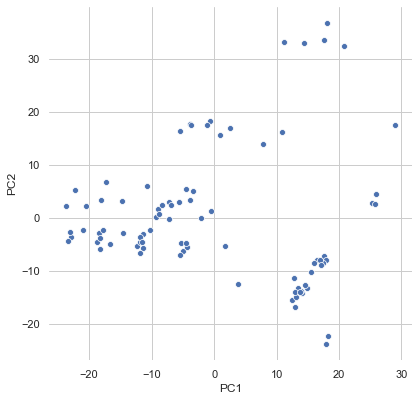

In [ ]:
desciptorsPCA(aa2descriptors_output)
plt.show()

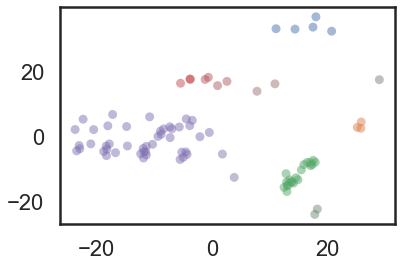

In [ ]:
cluster_PC(principalDf, 3, 1, 5, 1.0)

## **Fig. 3g**

/content/google_drive/My Drive/Colab Notebooks/ELMO1_nanobody_manuscript
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
rmsd_without_align = 0.9924130700894088
rmsd_with_align = 0.9847467578437278
rmsd_without_align = 1.0213465580005614
rmsd_with_align = 1.0123849967112994
rmsd_without_align = 1.2577689509494983
rmsd_with_align = 1.2529542236580706
rmsd_without_align = 0.9934058655308353
rmsd_with_align = 0.984488602934857
rmsd_without_align = 1.2288861314003146
rmsd_with_align = 1.222116151821394
rmsd_without_align = 1.2885178403836608
rmsd_with_align = 1.2783060193777758
rmsd_without_align = 1.0898985429918302
rmsd_with_align = 1.0851869036734534
rmsd_without_align = 0.9767516934596348
rmsd_with_align = 0.9517406852991446
rmsd_without_align = 0.8981629171654104
rmsd_with_align = 0.8919976272208766
rmsd_without_align = 1.031269861633594

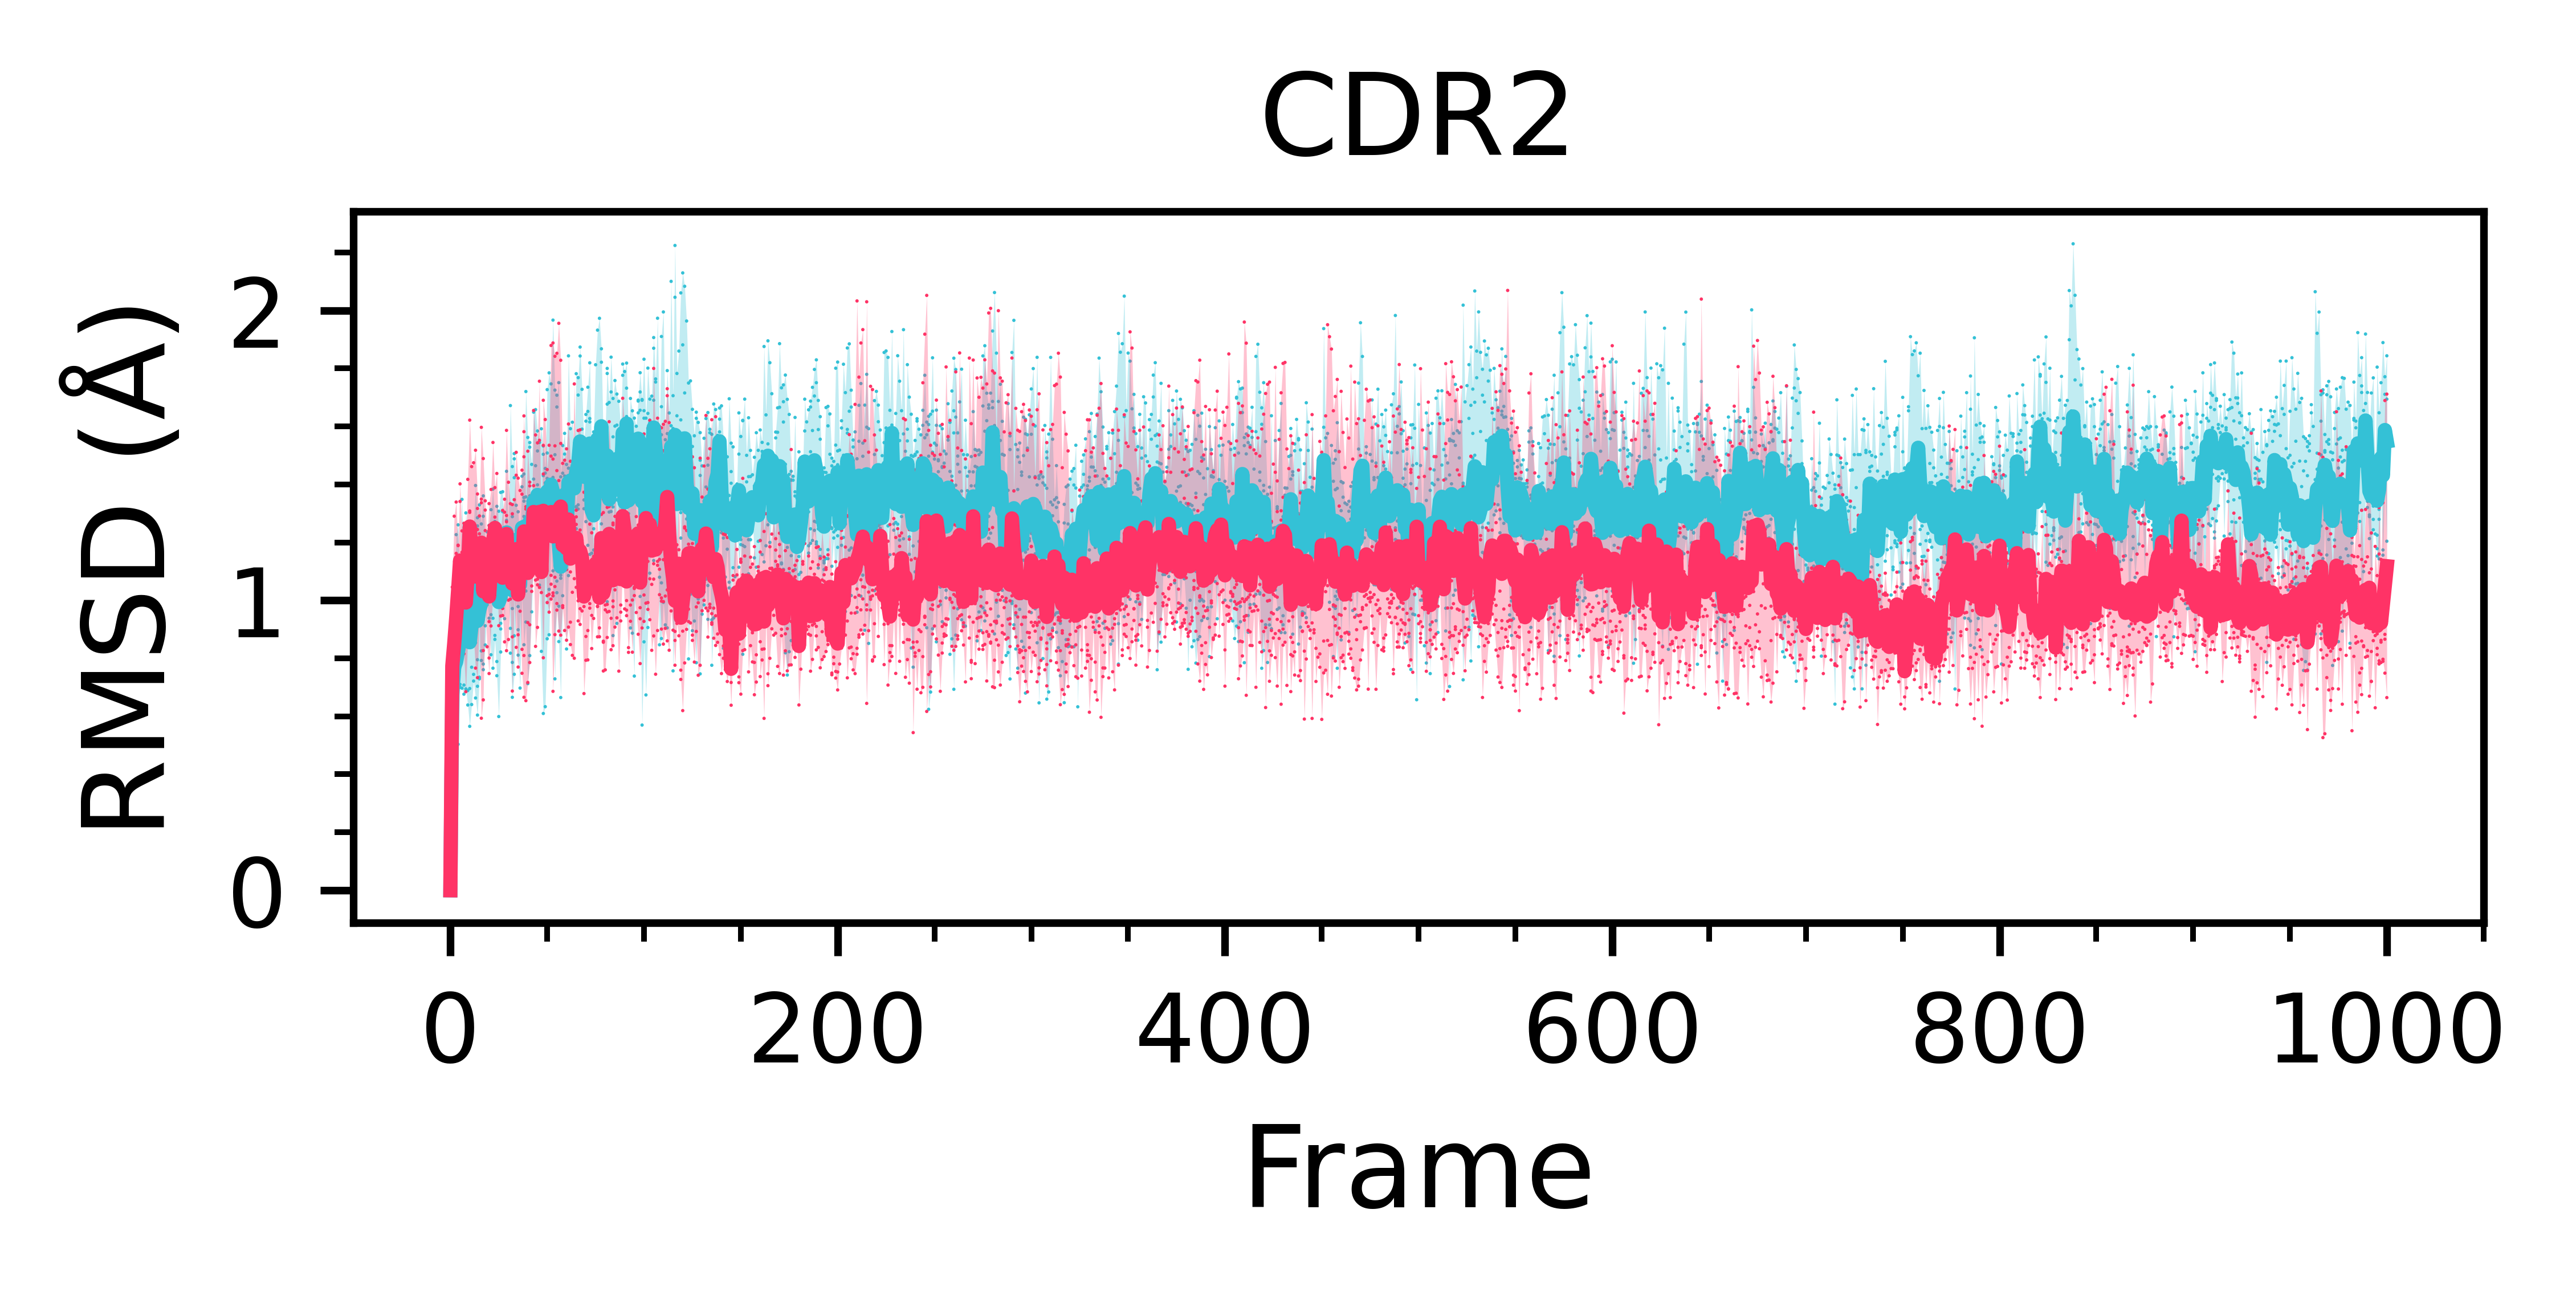

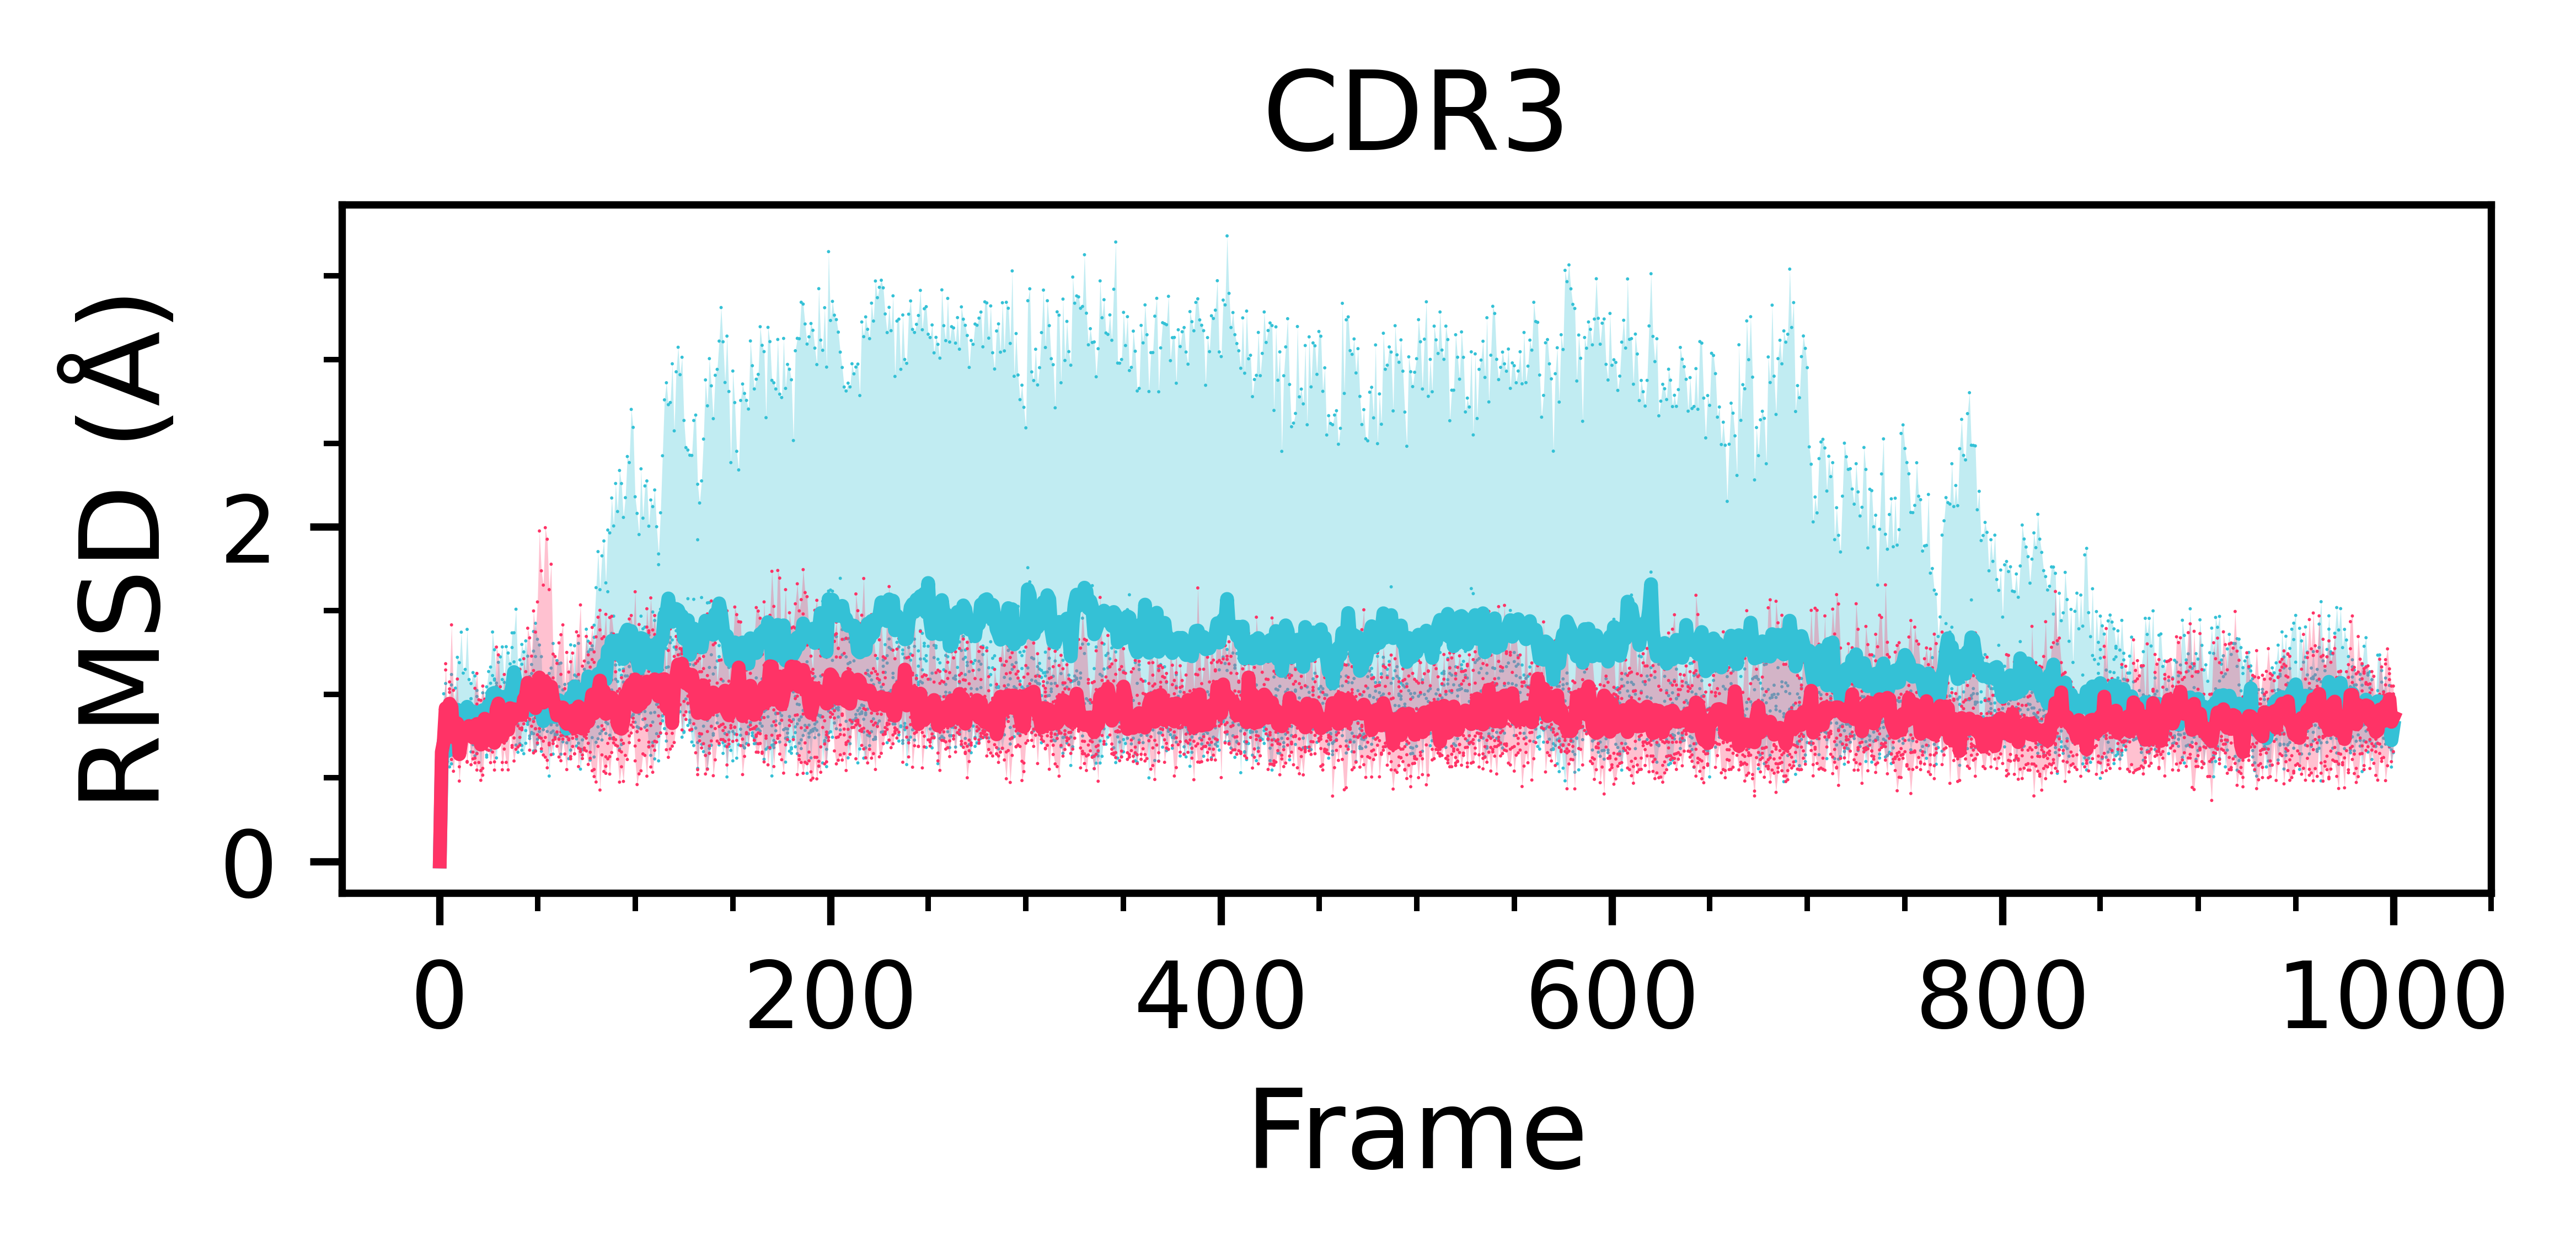

In [ ]:
!pip3 install --upgrade MDAnalysis
# Import MDanalysis
import MDAnalysis as mda
#from MDAnalysis.tests.datafiles import PSF, DCD, DCD2
from MDAnalysis.analysis import gnm
import matplotlib.pyplot as plt
%matplotlib inline
#Installing py3Dmol using pip
!pip install py3Dmol
import py3Dmol
import MDAnalysis as mda
from MDAnalysis.analysis import align, rms
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import glob
from scipy import stats


def rmsd_unalign_align(mobile, ref):

    # RMSD between 1st frame and last frame (without align trajectory)

    mobile.trajectory[-1]  # set mobile trajectory to last frame
    ref.trajectory[0]  # set reference trajectory to first frame

    mobile_ca = mobile.select_atoms('name CA')
    ref_ca = ref.select_atoms('name CA')
    rmsd_without_align = rms.rmsd(mobile_ca.positions, ref_ca.positions, superposition=False)

    # RMSD between 1st frame and last frame (with align trajectory)
    aligner = align.AlignTraj(mobile, ref, select='name CA', in_memory=True).run()

    mobile.trajectory[-1]  # set mobile trajectory to last frame
    ref.trajectory[0]  # set reference trajectory to first frame

    mobile_ca = mobile.select_atoms('name CA')
    ref_ca = ref.select_atoms('name CA')
    rmsd_with_align = rms.rmsd(mobile_ca.positions, ref_ca.positions, superposition=False)

    # Alternatively
    # rms.rmsd(mobile.select_atoms('backbone').positions,  # coordinates to align
    #          ref.select_atoms('backbone').positions,  # reference coordinates
    #          center=True,  # subtract the center of geometry
    #         superposition=True)  # superimpose coordinates

    print("rmsd_without_align =", rmsd_without_align)
    print("rmsd_with_align =", rmsd_with_align)

def rmsd_df(mobile, ref):

    # Here we define two 
    Loop1 = 'backbone and resid 57-69'
    Loop2 = 'backbone and resid 107-138'

    #Here we calculate the RMSD
    R_rmsd = rms.RMSD(mobile,  # universe to align
                ref,  # reference universe or atomgroup
                select='backbone',  # group to superimpose and calculate RMSD
                groupselections=[Loop1, Loop2],  # groups for RMSD
                ref_frame=0)  # frame index of the reference
    R_rmsd.run()

    # Convert to df
    df_rmsd = pd.DataFrame(R_rmsd.results.rmsd,
                          columns=['Frame', 'Time (ns)','Backbone','Loop1','Loop2'])

    return df_rmsd

# get all trajectories
filepath_list = []

for filepath in glob.iglob('./*_repeat*/'):
  filepath_list.append(filepath)

filepath_list.sort()

filepath_list_nano0906 = [ i for i in filepath_list if 'nano-0906' in i ]
filepath_list_nano79 = [ i for i in filepath_list if 'nano-79' in i ]

# tmp
#filepath_list_nano0906 = filepath_list_nano0906[:1]
#filepath_list_nano79 = filepath_list_nano79[:1]

df_rmsd_nano79_cdr2 = {}
df_rmsd_nano0906_cdr2 = {}
df_rmsd_nano79_cdr3 = {}
df_rmsd_nano0906_cdr3 = {}

for filepath_nano79, filepath_nano0906 in zip(filepath_list_nano79, filepath_list_nano0906):

    #Here we create two Universes each containing the same trajectory of the monomeric trajectory, 
    #one called mobile and the other ref which will be used as reference 
    mobile_nano79 = mda.Universe(filepath_nano79 + 'protein_fit.gro', filepath_nano79 + 'protein_fit.xtc')
    ref_nano79 = mda.Universe(filepath_nano79 + 'protein_fit.gro', filepath_nano79 + 'protein_fit.xtc')

    mobile_nano0906 = mda.Universe(filepath_nano0906 + 'protein_fit.gro', filepath_nano0906 + 'protein_fit.xtc')
    ref_nano0906 = mda.Universe(filepath_nano0906 + 'protein_fit.gro', filepath_nano0906 + 'protein_fit.xtc')

    # unaligned vs aligned RMSD
    rmsd_unalign_align(mobile_nano79, ref_nano79)
    rmsd_unalign_align(mobile_nano0906, ref_nano0906)

    # RMSD df
    df_rmsd_nano79 = rmsd_df(mobile_nano79, ref_nano79)
    df_rmsd_nano0906 = rmsd_df(mobile_nano0906, ref_nano0906)

    # append
    repeat_name_nano79 = filepath_nano79.split('/')[1]
    repeat_name_nano0906 = filepath_nano0906.split('/')[1]
    df_rmsd_nano79_cdr2[repeat_name_nano79] = df_rmsd_nano79['Loop1']
    df_rmsd_nano0906_cdr2[repeat_name_nano0906] = df_rmsd_nano0906['Loop1']
    df_rmsd_nano79_cdr3[repeat_name_nano79] = df_rmsd_nano79['Loop2']
    df_rmsd_nano0906_cdr3[repeat_name_nano0906] = df_rmsd_nano0906['Loop2']

# format

def format_rmsd_df(df_dict):

    df = pd.DataFrame(df_dict)
    df['rmsd_mean'] = df.mean(axis=1)
    df['rmsd_min'] = df.min(axis=1)
    df['rmsd_max'] = df.max(axis=1)
    df.insert(0, 'Time (ns)',df_rmsd_nano79['Time (ns)'])
    df.insert(0, 'Frame',df_rmsd_nano79['Frame'])

    return df

df_rmsd_nano79_cdr2 = format_rmsd_df(df_rmsd_nano79_cdr2)
df_rmsd_nano0906_cdr2 = format_rmsd_df(df_rmsd_nano0906_cdr2)
df_rmsd_nano79_cdr3 = format_rmsd_df(df_rmsd_nano79_cdr3)
df_rmsd_nano0906_cdr3 = format_rmsd_df(df_rmsd_nano0906_cdr3)

############
''' CDR2 '''
############

# band graph
fig, ax = plt.subplots(figsize=(4, 2), dpi=1200)

mean_plot = ax.plot(df_rmsd_nano79_cdr2['Frame'], df_rmsd_nano79_cdr2['rmsd_mean'], color='#34C1D6', linewidth=1.5, linestyle = "-", alpha=1.0)
scatter_plot = ax.scatter(df_rmsd_nano79_cdr2['Frame'], df_rmsd_nano79_cdr2['nano-79_apo_repeat1'], s=0.5, marker = '.', facecolors='#34C1D6', edgecolors='none')
scatter_plot = ax.scatter(df_rmsd_nano79_cdr2['Frame'], df_rmsd_nano79_cdr2['nano-79_apo_repeat2'], s=0.5, marker = '.', facecolors='#34C1D6', edgecolors='none')
scatter_plot = ax.scatter(df_rmsd_nano79_cdr2['Frame'], df_rmsd_nano79_cdr2['nano-79_apo_repeat3'], s=0.5, marker = '.', facecolors='#34C1D6', edgecolors='none')
scatter_plot = ax.scatter(df_rmsd_nano79_cdr2['Frame'], df_rmsd_nano79_cdr2['nano-79_apo_repeat4'], s=0.5, marker = '.', facecolors='#34C1D6', edgecolors='none')
scatter_plot = ax.scatter(df_rmsd_nano79_cdr2['Frame'], df_rmsd_nano79_cdr2['nano-79_apo_repeat5'], s=0.5, marker = '.', facecolors='#34C1D6', edgecolors='none')
min_max_plot = ax.fill_between(df_rmsd_nano79_cdr2['Frame'], df_rmsd_nano79_cdr2['rmsd_min'], df_rmsd_nano79_cdr2['rmsd_max'], lw=0, color='#34C1D6', alpha=0.3)

mean_plot = ax.plot(df_rmsd_nano0906_cdr2['Frame'], df_rmsd_nano0906_cdr2['rmsd_mean'], color='#ff3366', linewidth=1.5, linestyle = "-", alpha=1.0)
scatter_plot = ax.scatter(df_rmsd_nano0906_cdr2['Frame'], df_rmsd_nano0906_cdr2['nano-0906_apo_repeat1'], s=0.5, marker = '.', facecolors='#ff3366', edgecolors='none')
scatter_plot = ax.scatter(df_rmsd_nano0906_cdr2['Frame'], df_rmsd_nano0906_cdr2['nano-0906_apo_repeat2'], s=0.5, marker = '.', facecolors='#ff3366', edgecolors='none')
scatter_plot = ax.scatter(df_rmsd_nano0906_cdr2['Frame'], df_rmsd_nano0906_cdr2['nano-0906_apo_repeat3'], s=0.5, marker = '.', facecolors='#ff3366', edgecolors='none')
scatter_plot = ax.scatter(df_rmsd_nano0906_cdr2['Frame'], df_rmsd_nano0906_cdr2['nano-0906_apo_repeat4'], s=0.5, marker = '.', facecolors='#ff3366', edgecolors='none')
scatter_plot = ax.scatter(df_rmsd_nano0906_cdr2['Frame'], df_rmsd_nano0906_cdr2['nano-0906_apo_repeat5'], s=0.5, marker = '.', facecolors='#ff3366', edgecolors='none')
min_max_plot = ax.fill_between(df_rmsd_nano0906_cdr2['Frame'], df_rmsd_nano0906_cdr2['rmsd_min'], df_rmsd_nano0906_cdr2['rmsd_max'], lw=0, color='#ff3366', alpha=0.3)

plt.title('CDR2', size = 12)
plt.xlabel('Frame', size=12)
plt.ylabel('RMSD (Å)', size=12)
ax.yaxis.get_ticklocs(minor=False)
ax.minorticks_on()
#plt.legend()
plt.tight_layout()
plt.show()


############
''' CDR3 '''
############

# band graph
fig, ax = plt.subplots(figsize=(4, 2), dpi=1200)

mean_plot = ax.plot(df_rmsd_nano79_cdr3['Frame'], df_rmsd_nano79_cdr3['rmsd_mean'], color='#34C1D6', linewidth=1.5, linestyle = "-", alpha=1.0)
scatter_plot = ax.scatter(df_rmsd_nano79_cdr3['Frame'], df_rmsd_nano79_cdr3['nano-79_apo_repeat1'], s=0.5, marker = '.', facecolors='#34C1D6', edgecolors='none')
scatter_plot = ax.scatter(df_rmsd_nano79_cdr3['Frame'], df_rmsd_nano79_cdr3['nano-79_apo_repeat2'], s=0.5, marker = '.', facecolors='#34C1D6', edgecolors='none')
scatter_plot = ax.scatter(df_rmsd_nano79_cdr3['Frame'], df_rmsd_nano79_cdr3['nano-79_apo_repeat3'], s=0.5, marker = '.', facecolors='#34C1D6', edgecolors='none')
scatter_plot = ax.scatter(df_rmsd_nano79_cdr3['Frame'], df_rmsd_nano79_cdr3['nano-79_apo_repeat4'], s=0.5, marker = '.', facecolors='#34C1D6', edgecolors='none')
scatter_plot = ax.scatter(df_rmsd_nano79_cdr3['Frame'], df_rmsd_nano79_cdr3['nano-79_apo_repeat5'], s=0.5, marker = '.', facecolors='#34C1D6', edgecolors='none')
min_max_plot = ax.fill_between(df_rmsd_nano79_cdr3['Frame'], df_rmsd_nano79_cdr3['rmsd_min'], df_rmsd_nano79_cdr3['rmsd_max'], lw=0, color='#34C1D6', alpha=0.3)

mean_plot = ax.plot(df_rmsd_nano0906_cdr3['Frame'], df_rmsd_nano0906_cdr3['rmsd_mean'], color='#ff3366', linewidth=1.5, linestyle = "-", alpha=1.0)
scatter_plot = ax.scatter(df_rmsd_nano0906_cdr3['Frame'], df_rmsd_nano0906_cdr3['nano-0906_apo_repeat1'], s=0.5, marker = '.', facecolors='#ff3366', edgecolors='none')
scatter_plot = ax.scatter(df_rmsd_nano0906_cdr3['Frame'], df_rmsd_nano0906_cdr3['nano-0906_apo_repeat2'], s=0.5, marker = '.', facecolors='#ff3366', edgecolors='none')
scatter_plot = ax.scatter(df_rmsd_nano0906_cdr3['Frame'], df_rmsd_nano0906_cdr3['nano-0906_apo_repeat3'], s=0.5, marker = '.', facecolors='#ff3366', edgecolors='none')
scatter_plot = ax.scatter(df_rmsd_nano0906_cdr3['Frame'], df_rmsd_nano0906_cdr3['nano-0906_apo_repeat4'], s=0.5, marker = '.', facecolors='#ff3366', edgecolors='none')
scatter_plot = ax.scatter(df_rmsd_nano0906_cdr3['Frame'], df_rmsd_nano0906_cdr3['nano-0906_apo_repeat5'], s=0.5, marker = '.', facecolors='#ff3366', edgecolors='none')
min_max_plot = ax.fill_between(df_rmsd_nano0906_cdr3['Frame'], df_rmsd_nano0906_cdr3['rmsd_min'], df_rmsd_nano0906_cdr3['rmsd_max'], lw=0, color='#ff3366', alpha=0.3)

plt.title('CDR3', size = 12)
plt.xlabel('Frame', size=12)
plt.ylabel('RMSD (Å)', size=12)
ax.yaxis.get_ticklocs(minor=False)
ax.minorticks_on()
#plt.legend()
plt.tight_layout()
plt.show()